# Introduction à l'I/O Asynchrone

#Le Socket de Berkeley

Il est difficile d'imaginer le nombre d'instanciations d'objets de type Socket depuis leur introduction en 1983 à l'université Berkeley.

Le Socket est l'interface de programmation la plus populaire pour faire de la réseautique.

Elle est si populaire, que tous les systèmes d'exploitation l'offrent et tous les étudiants sont introduits à la programmation réseau avec les Sockets.

# Exemple d'un Socket client qui se connecte 

In [1]:
from IPython.display import Image
from IPython.display import display

In [2]:
import socket

sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
sock.connect(("etsmtl.ca" , 80))

#Exemple d'un Socket client qui envoi des données

In [3]:
msg = b'GET /ETS/media/Prive/logo/ETS-rouge-devise-ecran.jpg HTTP/1.1\r\nHost:etsmtl.ca\r\n\r\n'
sock.sendall(msg)

#Exemple d'un Socket qui reçoit des données

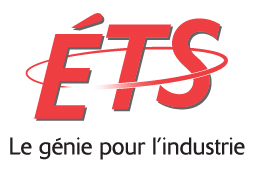

In [4]:
recvd = b''
while True:
    data = sock.recv(1024)
    if not data: 
        break
    recvd += data

sock.shutdown(1)
sock.close()

response = recvd.split(b'\r\n\r\n', 1)
Image(data=response[1])

Quoique les versions de l'interface Socket ont évolué avec les années, surtout sur les plateformes orientées-objet, l'essence de l'interface de 1983 reste très présente dans les implémentations modernes.

```2.3.1.5. Making connections
 connect(s, name, namelen);```

```2.3.1.6. Sending and receiving data
 cc = sendto(s, buf, len, flags, to, tolen);
 msglen = recvfrom(s, buf, len, flags, from, fromlenaddr);
```

Extrait du [manuel system de BSD 4.2](http://www.cilinder.be/docs/bsd/4.2BSD_Unix_system_manual.pdf) [1983]

#Socket Synchrone
Le Socket Berkeley de 1983 est synchrone

Ceci implique que lorsqu'une fonction comme ```connect```, ```sendto```, ```recvfrom```... est invoquée, **le processus bloque jusqu'à l'obtention de la réponse**. 

Notons la présence dans le même document d'une fonction d'I/O asynchrone. 

# Fail Whale

Le Socket synchrone n'est pas efficace en conditions de charge élevée

Le déploiement de réseaux haute vitesse combiné à l'explosion de la popularité des réseaux sociaux le démontre bien

![FailWhale](FailWhale.jpg)

Les sites de réseau sociaux ne savent pas comment gérer cette impasse. 

La situation est telle, que les pages d'erreurs de Twitter deviennent célèbres.

#Le Problème:

Lors d'un appel bloquant, le processus et ses ressources sont suspendus. Lorsque la charge augmente, la quantité de ressources suspendue devient ingérable pour le système d'exploitation

# La Solution:

**Il ne faut pas bloquer**

# Le Socket Asynchrone

Dès 1983, le socket de Berkley offre un mode asynchrones. Cependant, il n'est pas très utilisé, car ils sont beaucoup plus complexes et prône à l'erreur.

#Le Patron Reactor

En 1995, le Patron Reactor est découvert

ce patron simplifie grandement l'I/O Asynchrone

http://www.dre.vanderbilt.edu/~schmidt/PDF/reactor-siemens.pdf

Une influence est du patron Reactor est la fonction Select

*Select est la fonction asynchrone présentée dans le même document que le Socket*

# Exemple d'un Socket client asynchrone qui se connecte
# (Avec le Patron Reactor)


In [5]:
import selectors
import socket
import errno 

sel = selectors.DefaultSelector()

In [6]:
def connector(sock, mask):
    msg = b'GET /ETS/media/Prive/logo/ETS-rouge-devise-ecran.jpg HTTP/1.1\r\nHost:etsmtl.ca\r\n\r\n'
    sock.sendall(msg)
    # Le connector a pour responsabilité 
    # d'instancier un nouveau Handler
    # et de l'ajouter au Selector
    h = HTTPHandler()
    sel.modify(sock, selectors.EVENT_READ, h.handle)

In [7]:
class HTTPHandler:
    
    recvd = b''
    
    def handle(self, sock, mask):
        data = sock.recv(1024)
        if not data:
            # Le Handler se retire 
            # lorsqu'il a terminé.
            sel.unregister(sock)
            response = self.recvd.split(b'\r\n\r\n', 1)
            display(Image(data=response[1]))
            
        else:
            self.recvd += data

# Création d'un Socket Asynchrone

In [8]:
sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)

sock.setblocking(False)
try:
    sock.connect(("etsmtl.ca" , 80))
except socket.error:
    pass # L'exception est toujours lancé!
         # C'est normal, l'OS veut nous avertir que 
         # nous ne sommes pas encore connecté


#Enregistrement du Connector

In [9]:
# L'application enregistre le Connector
sel.register(sock, selectors.EVENT_WRITE, connector)

SelectorKey(fileobj=<socket.socket fd=63, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 52631), raddr=('127.0.0.1', 5001)>, fd=63, events=2, data=<function connector at 0x10a29d840>)

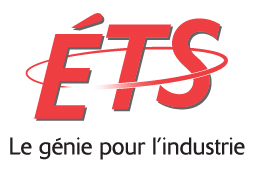

In [10]:
# Le Reactor
while len(sel.get_map()):
    events = sel.select()
    for key, mask in events:
        handleEvent = key.data
        handleEvent(key.fileobj, mask)